In [39]:
import torch
from torch import nn
import torchvision
from torchvision import models
from torchvision import datasets, transforms
from datetime import datetime
import sys
from tqdm import tqdm
from utils import get_mean_and_std
import matplotlib.pyplot as plt

In [2]:
print(sys.version_info)
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
print(torch.cuda.get_device_name())

sys.version_info(major=3, minor=6, micro=13, releaselevel='final', serial=0)
1.10.2
0.11.3
True
NVIDIA A10


## vgg => resnet

In [5]:
# train
model = models.resnet18(pretrained=False, num_classes=10)

In [8]:
# fine-tune
model = models.resnet18(pretrained=True, )
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)

In [12]:
from torchsummary import summary

In [13]:
summary(model, input_size=(3, 224, 224), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## parameters

In [37]:
classes = ('plane', 'car' , 'bird',
    'cat', 'deer', 'dog',
    'frog', 'horse', 'ship', 'truck')

In [14]:
# dataset
# input_shape = 32
num_classes = 10

# hyper 
batch_size = 64
num_epochs = 5
learning_rate = 1e-3

# gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
device

device(type='cuda')

## dataset 与 dataloader

In [12]:
# offline calc mean/std of training dataset
train_dataset = datasets.CIFAR10(root='../data/', 
                               download=True, 
                               train=True, 
                               transform=transforms.ToTensor())
test_dataset = datasets.CIFAR10(root='../data/', 
                               download=True, 
                               train=False, 
                               transform=transforms.ToTensor())
get_mean_and_std(train_dataset)

Files already downloaded and verified
Files already downloaded and verified


In [16]:
transform = transforms.Compose([
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))
])

In [17]:
train_dataset = datasets.CIFAR10(root='../data/', 
                               download=True, 
                               train=True, 
                               transform=transform)
test_dataset = datasets.CIFAR10(root='../data/', 
                               download=True, 
                               train=False, 
                               transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [18]:
train_dataloader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                               shuffle=True, 
                                               batch_size=batch_size)
test_dataloader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                               shuffle=False, 
                                               batch_size=batch_size)

In [19]:
images, labels = next(iter(train_dataloader))

In [20]:
# batch_size, channels, h, w
images.shape

torch.Size([64, 3, 224, 224])

## model arch

In [21]:
model = models.resnet18(pretrained=True)
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, 10)
model = model.to(device)

## model train/fine-tune

In [22]:
criterion = nn.CrossEntropyLoss()
# optimzier = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9,weight_decay=5e-4)
total_batch = len(train_dataloader)

In [23]:
for epoch in range(num_epochs):
    for batch_idx, (images, labels) in enumerate(train_dataloader):
        images = images.to(device)
        labels = labels.to(device)
        
        # forward
        out = model(images)
        loss = criterion(out, labels)
        
        # 标准的处理，用 validate data；这个过程是监督训练过程，用于 early stop
        n_corrects = (out.argmax(axis=1) == labels).sum().item()
        acc = n_corrects/labels.size(0)
        
        # backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()   # 更细 模型参数
        
        if (batch_idx+1) % 100 == 0:
            print(f'{datetime.now()}, {epoch+1}/{num_epochs}, {batch_idx+1}/{total_batch}: {loss.item():.4f}, acc: {acc}')

2023-03-01 21:41:17.984765, 1/5, 100/782: 0.7093, acc: 0.78125
2023-03-01 21:41:25.455140, 1/5, 200/782: 0.4392, acc: 0.875
2023-03-01 21:41:32.947964, 1/5, 300/782: 0.4320, acc: 0.828125
2023-03-01 21:41:40.381313, 1/5, 400/782: 0.2014, acc: 0.96875
2023-03-01 21:41:47.791212, 1/5, 500/782: 0.2910, acc: 0.90625
2023-03-01 21:41:55.273383, 1/5, 600/782: 0.2055, acc: 0.9375
2023-03-01 21:42:02.693802, 1/5, 700/782: 0.3474, acc: 0.828125
2023-03-01 21:42:16.217742, 2/5, 100/782: 0.3255, acc: 0.90625
2023-03-01 21:42:23.644158, 2/5, 200/782: 0.1511, acc: 0.9375
2023-03-01 21:42:31.016172, 2/5, 300/782: 0.1535, acc: 0.984375
2023-03-01 21:42:38.376984, 2/5, 400/782: 0.1198, acc: 0.96875
2023-03-01 21:42:45.718505, 2/5, 500/782: 0.2236, acc: 0.90625
2023-03-01 21:42:53.216509, 2/5, 600/782: 0.2121, acc: 0.953125
2023-03-01 21:43:00.666309, 2/5, 700/782: 0.2515, acc: 0.953125
2023-03-01 21:43:14.084188, 3/5, 100/782: 0.1586, acc: 0.96875
2023-03-01 21:43:21.414939, 3/5, 200/782: 0.1409, acc:

## model evaluation

In [33]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

In [35]:
unnormalize = UnNormalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))

In [36]:
total = 0
correct = 0

all_mis_preds = []
all_mis_labels = []
all_mis_images = []

for images, labels in tqdm(test_dataloader):
    images = images.to(device)
    labels = labels.to(device)
    out = model(images)
    preds = torch.argmax(out, dim=1)
    total += images.size(0)
    correct += (preds == labels).sum().item()
    
    mis_preds_indice = torch.flatten((preds != labels).nonzero())
    mis_preds = preds[mis_preds_indice]
    mis_labels = labels[mis_preds_indice]
    mis_images = images[mis_preds_indice]
    
    all_mis_preds.extend(mis_preds)
    all_mis_labels.extend(mis_labels)
    
    for i in range(mis_images.size(0)):
        all_mis_images.append(unnormalize(mis_images[i]))
    
print(f'{correct}/{total}={correct/total}')

100%|██████████| 157/157 [00:10<00:00, 14.36it/s]

9424/10000=0.9424


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


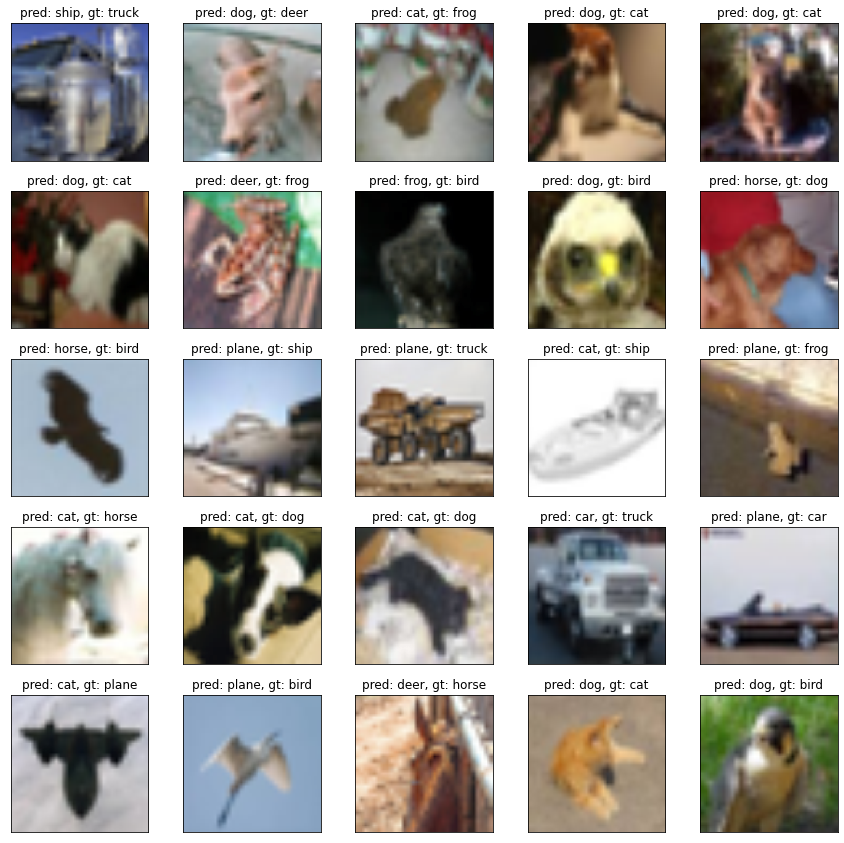

In [40]:
fig = plt.figure(figsize=(12, 12))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.tight_layout()
    plt.imshow(np.transpose(all_mis_images[i].cpu(), (1, 2, 0)), interpolation='none')
    plt.title("pred: {}, gt: {}".format(classes[all_mis_preds[i].item()], classes[all_mis_labels[i].item()]))
    plt.xticks([])
    plt.yticks([])

## model save

In [ ]:
torch.save(model.state_dict(), 'resnet18_cifar10.ckpt')